In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import dowhy
from dowhy import CausalModel
import dowhy.datasets as ds, dowhy.plotter
import econml

In [2]:
data = pd.read_csv("../data/data.csv")
y = data.diagnosis                          # M or B 
list = ['Unnamed: 32','id','diagnosis']
x = data.drop(list,axis = 1 )
x.shape

### Feature Selection with correlation

In [3]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = x.drop(drop_list1,axis = 1 )        # do not modify x, we will use it later 
x_1.head()

,texture_mean,area_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,10.38,1001.0,0.11840,0.3001,0.2419,0.07871,0.9053,153.40,0.006399,0.05373,0.03003,0.006193,0.1622,0.7119,0.4601,0.11890
1,17.77,1326.0,0.08474,0.0869,0.1812,0.05667,0.7339,74.08,0.005225,0.01860,0.01389,0.003532,0.1238,0.2416,0.2750,0.08902
2,21.25,1203.0,0.10960,0.1974,0.2069,0.05999,0.7869,94.03,0.006150,0.03832,0.02250,0.004571,0.1444,0.4504,0.3613,0.08758
3,20.38,386.1,0.14250,0.2414,0.2597,0.09744,1.1560,27.23,0.009110,0.05661,0.05963,0.009208,0.2098,0.6869,0.6638,0.17300
4,14.34,1297.0,0.10030,0.1980,0.1809,0.05883,0.7813,94.44,0.011490,0.05688,0.01756,0.005115,0.1374,0.4000,0.2364,0.07678


#### check accuracy

Accuracy is:  0.9649122807017544


<AxesSubplot:>

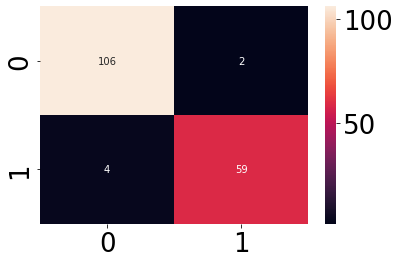

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

### Univariate Feature Selction

* use SelectKBest that removes all but the k highest scoring features
* k = 5 for accuracy

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 15 features
select_feature = SelectKBest(chi2, k=10).fit(x_train, y_train)

In [10]:
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

Score list: [6.06916433e+01 3.66899557e+04 1.00015175e-01 1.30547650e+01
 1.95982847e-01 3.42575072e-04 4.07131026e-02 6.12741067e+03
 1.32470372e-03 6.92896719e-01 1.39557806e-03 2.65927071e-03
 2.63226314e-01 2.58858117e+01 1.00635138e+00 1.23087347e-01]
Feature list: Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se',
       'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')


Accuracy is:  0.9707602339181286


<AxesSubplot:>

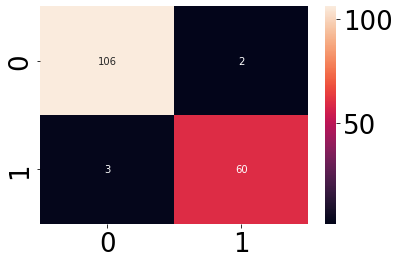

In [11]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

## Choose features by RFE

In [12]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=15, step=1)
rfe = rfe.fit(x_train, y_train)

In [13]:
print('Chosen best 10 feature by rfe:',x_train.columns[rfe.support_])

Chosen best 10 feature by rfe: Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'texture_se', 'area_se', 'smoothness_se',
       'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')


In [14]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])


Optimal number of features : 13
Best features : Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'area_se', 'smoothness_se', 'concavity_se',
       'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [15]:
columns = ['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'area_se', 'smoothness_se', 'concavity_se',
       'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [16]:
data2 = pd.DataFrame()
data2[columns] = data[columns]

In [18]:
data2["diagnosis"] = data["diagnosis"]
data2.to_csv("../data/data2.csv")

Let's use Random Forest to see if our feature choice is accurate

Well it looks like our feature selection is good we have accuracy of 100%

SPLIT DATA TO TRAIN AND HOLD OUT SET

In [19]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, random_state=20, test_size=.2)

In [20]:
train_df.shape

In [21]:
valid_df.shape

DEFINE CAUSAL MODEL

In [22]:
d = ds.linear_dataset(beta=5,
    num_common_causes=5,
    num_instruments = 0,
    num_samples=10000,
    treatment_is_binary=True)

In [23]:
d["dot_graph"] = 'digraph { U[label="Unobserved Confounders"];U->Diagnosis;area_mean->Diagnosis;concavity_mean->Diagnosis;area_se->Diagnosis;symmetry_worst->Diagnosis;concavity_worst->Diagnosis;symmetry_se->Diagnosis;concavity_se->Diagnosis;smoothness_se->Diagnosis;fractal_dimension_mean->Diagnosis;smoothness_mean->Diagnosis;symmetry_se->Diagnosis;fractal_dimension_se->Diagnosis;smoothness_worst->Diagnosis;fractal_dimension_worst->Diagnosis;}'

In [24]:
model = CausalModel(
    data = train_df,
    treatment = ["Diagnosis"],
    outcome = "Diagnosis",
    graph = d["dot_graph"]
)

In [25]:
model.view_model()

In [26]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[Diagnosis|symmetryₛₑ])
d[Diagnosis]                         
Estimand assumption 1, Unconfoundedness: If U→{Diagnosis} and U→Diagnosis then P(Diagnosis|Diagnosis,symmetry_se,U) = P(Diagnosis|Diagnosis,symmetry_se)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                                                                            
E⎢────────────────────────────────────────────────────────────────────────────
 ⎣d[areaₘₑₐₙ  smoothness_worst  U  concavity_worst  fractal_dimension_worst  a

                                                                              
                        d                                                     
──────────────────────────────────────────────────────────────────────────────
reaₛₑ  fractal_dimension_s

CALCULATE CAUSAL EFFECT BASED ON ESTIMAND

In [27]:
d["gml_graph"]

'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "v0" label "v0"]edge[source "Unobserved Confounders" target "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]]'

In [28]:
model = CausalModel(
    data = data,
    treatment = ["Diagnosis"],
    outcome = "Diagnosis",
    graph = d["dot_graph"]
)

In [29]:
ds.linear_dataset(beta=5,
    num_common_causes=5,
    num_instruments = 0,
    num_samples=10000,
    treatment_is_binary=True)

{'df':             W0        W1        W2        W3        W4     v0          y
 0     1.574443  2.412372 -1.287072 -0.672173 -0.501163   True   8.698336
 1     1.000270 -0.005022 -0.540266 -0.438900 -0.424498  False  -0.306369
 2    -0.346872  1.096617 -0.229747 -2.425565  0.640758  False  -2.087802
 3     1.328827  1.423777 -1.410905 -0.665375 -1.308448  False   1.265399
 4     0.581511 -0.108188 -2.796360  0.380182  2.273173   True   6.298504
 ...        ...       ...       ...       ...       ...    ...        ...
 9995  1.853734  1.606587  0.410785  0.803293 -0.798394   True  10.401008
 9996  0.412527  2.004730  0.586689 -0.878391  0.060679   True   7.642583
 9997  0.895040 -0.106528  1.491454 -0.844096 -0.854148  False  -0.785617
 9998 -1.408759 -0.081169  0.121273 -0.597193  1.152199  False  -1.622317
 9999 -0.004182 -0.229512  2.637425 -0.036325  1.345443   True   6.259929
 
 [10000 rows x 7 columns],
 'treatment_name': ['v0'],
 'outcome_name': 'y',
 'common_causes_names': ['W0

In [30]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)


In [34]:
#Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

# Compute causal effect using metalearner
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model.estimate_effect(identified_estimand_experiment,                             method_name="backdoor.econml.metalearners.TLearner",
confidence_intervals=False,
method_params={
     "init_params":{'models': RandomForestRegressor()},
     "fit_params":{}
              })
print(metalearner_estimate)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W3,W0,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,W4,U) = P(y|v0,W1,W3,W0,W2,W4)

## Realized estimand
b: y~v0+W1+W3+W0+W2+W4
Target units: ate

## Estimate
Mean value: 12.263886508983562
Effect estimates: [10.23526242 15.11734615 14.05898698 ... 15.55548593 11.03219149
 11.85952911]



(array([5.800e+01, 2.684e+03, 3.785e+03, 1.851e+03, 9.250e+02, 4.250e+02,
        1.940e+02, 6.200e+01, 1.400e+01, 2.000e+00]),
 array([ 6.87613664,  8.77055049, 10.66496433, 12.55937817, 14.45379202,
        16.34820586, 18.24261971, 20.13703355, 22.0314474 , 23.92586124,
        25.82027509]),
 <BarContainer object of 10 artists>)

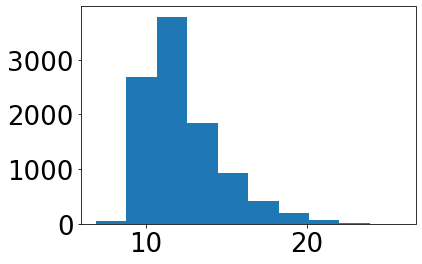

In [35]:
# Print histogram of causal effects
import matplotlib.pyplot as plt
plt.hist(metalearner_estimate.cate_estimates)

Since the causal effect is not Gaussian distributed the mean doesn't represnet the overall disribution.